# Compute viable habitat in trait space

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import shutil
from itertools import product

import data_collections as dc
import funnel
import intake
import matplotlib.pyplot as plt
import metabolic as mi
import numpy as np
import operators as ops
import util
import xarray as xr
import yaml

/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
curator = util.curator_local_assets()
cat = curator.open_catalog()
ds_ts = cat['trait-space'].to_dask().load()
trait_spc_wgt = ds_ts.trait_spc_active
trait_spc_wgt

<xarray.DataArray 'trait_spc_active' (Ac: 12, Eo: 11)>
array([[1.00358230e-04, 6.72698399e-04, 2.81408643e-03, 7.33609608e-03,
        1.19297474e-02, 1.27449962e-02, 1.20953656e-02, 7.64600251e-03,
        3.01496564e-03, 7.40878515e-04, 1.13620084e-04],
       [2.15385464e-04, 1.44372273e-03, 6.03949784e-03, 1.57444832e-02,
        2.56032234e-02, 2.73528831e-02, 2.59586678e-02, 1.64095940e-02,
        6.47061807e-03, 1.59004860e-03, 2.43847612e-04],
       [2.90987855e-04, 1.95048344e-03, 8.15942028e-03, 2.12709498e-02,
        3.45902036e-02, 3.69540110e-02, 3.50704125e-02, 2.21695209e-02,
        8.74186790e-03, 2.14817112e-03, 3.29440494e-04],
       [3.03348682e-04, 2.03333771e-03, 8.50602299e-03, 2.21745151e-02,
        3.60595553e-02, 3.85237745e-02, 3.65601629e-02, 2.31112565e-02,
        9.11321231e-03, 2.23942293e-03, 3.43434744e-04],
       [2.65211673e-04, 1.77770641e-03, 7.43664545e-03, 1.93867342e-02,
        3.15261466e-02, 3.36805640e-02, 3.19638178e-02, 2.02057084e-02,
        7.96749890e-03, 1.95788259e-03, 3.00258114e-04],
       [2.02910265e-04, 1.36010182e-03, 5.68968808e-03, 1.48325574e-02,
        2.41202760e-02, 2.57685949e-02, 2.44551330e-02, 1.54591447e-02,
        6.09583768e-03, 1.49795245e-03, 2.29723876e-04],
       [1.38808801e-04, 9.30431502e-04, 3.89225641e-03, 1.01467982e-02,
        1.65004298e-02, 1.76280276e-02, 1.67295020e-02, 1.05754401e-02,
        4.17009913e-03, 1.02473368e-03, 1.57151713e-04],
       [8.60027226e-05, 5.76473839e-04, 2.41155205e-03, 6.28672147e-03,
        1.02232847e-02, 1.09219182e-02, 1.03652125e-02, 6.55229806e-03,
        2.58369697e-03, 6.34901290e-04, 9.73675666e-05],
       [4.88294430e-05, 3.27302387e-04, 1.36919786e-03, 3.56938825e-03,
        5.80443598e-03, 6.20109650e-03, 5.88501779e-03, 3.72017367e-03,
        1.46693593e-03, 3.60475522e-04, 5.52820178e-05],
       [2.54539295e-05, 1.70616976e-04, 7.13738753e-04, 1.86065930e-03,
        3.02575035e-03, 3.23252251e-03, 3.06775624e-03, 1.93926109e-03,
        7.64687892e-04, 1.87909548e-04, 2.88175433e-05],
       [1.22509648e-05, 8.21178736e-05, 3.43522140e-04, 8.95534480e-04,
        1.45629228e-03, 1.55581163e-03, 1.47650969e-03, 9.33365485e-04,
        3.68043938e-04, 9.04407805e-05, 1.38698706e-05],
       [5.43994403e-06, 3.64637924e-05, 1.52538289e-04, 3.97655003e-04,
        6.46655070e-04, 6.90845848e-04, 6.55632452e-04, 4.14453562e-04,
        1.63427000e-04, 4.01595133e-05, 6.15880634e-06]])
Coordinates:
  * Ac       (Ac) float64 0.03 0.037 0.0456 0.0562 ... 0.1601 0.1974 0.2433 0.3
  * Eo       (Eo) float64 -0.5 -0.3056 -0.1111 0.0833 ... 0.8611 1.056 1.25
Attributes:
    N_traits:            132
    long_name:           Trait density (active)
    metabolic_baseline:  active
    units:               eV 1/kPa

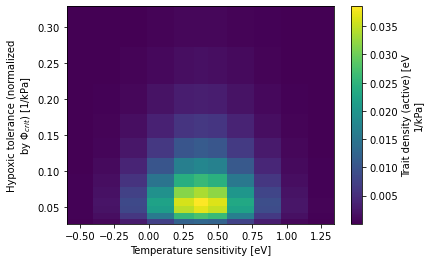

In [4]:
trait_spc_wgt.plot();

In [5]:
dEodT_bar = mi.dEodT_bar
dEodT_bar

0.022

In [6]:
sub_spec = dict(
    name='drift-corrected',
    experiment=['20C', 'RCP85'],
    member_id=dc.ocean_bgc_member_ids[1:],
)

catalog = funnel.to_intake_esm(agg_member_id=True).search(**sub_spec)
catalog

,unique
experiment,2
component,1
stream,1
member_id,31
variable,8
name,1
path,451


In [7]:
catalog.search(experiment='20C', variable=['pO2', 'TEMP'], member_id=10).df

,experiment,component,stream,member_id,variable,name,path
0,20C,ocn,pop.h,10,TEMP,drift-corrected,/glade/scratch/mclong/ocean-metabolism/funnel-...
1,20C,ocn,pop.h,10,pO2,drift-corrected,/glade/scratch/mclong/ocean-metabolism/funnel-...


In [8]:
try:
    cluster
    client
except:
    cluster, client = util.get_ClusterClient(memory='6GB')
    cluster.scale(200)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/asm/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/asm/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.51:43366,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/asm/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [9]:
# refresh catalog
catalog = funnel.to_intake_esm(agg_member_id=False).search(**sub_spec)
experiment_list = sorted(catalog.unique('experiment')['experiment']['values'])
member_id_list = sorted(catalog.unique('member_id')['member_id']['values'])

In [10]:
clobber = False

do_apply_ufunc = False

phi_upper_bound = 2.0

stream = "pop.h"
component = "ocn"

variable = "area_habitat_trait_spc"

# compute Phi over trait space
for experiment, member_id in product(experiment_list, member_id_list):
    # check for existing cache file

    asset = dc.fnl_gen_cache_file_name(
        experiment, component, stream, member_id, variable, "drift-corrected"
    )

    if clobber and os.path.exists(asset):
        print(f"removing: {asset}")
        shutil.rmtree(asset)

    if os.path.exists(asset):
        print(f"exists: {asset}")
        continue

    with util.timer(f"{experiment}.{member_id}"):

        cat = catalog.search(
            experiment=experiment,
            member_id=member_id,
            stream=stream,
            component=component,
            variable=["TEMP", "pO2"],
        )

        dset = cat.to_dataset_dict()
        assert len(dset.keys()) == 1
        _, ds = dset.popitem()

        dso = xr.Dataset()
        # vol = ds.dz * ds.TAREA

        print(f"computing: {asset}")
        da_list_outer = []
        for i, Ac in enumerate(trait_spc_wgt.Ac.values):

            da_list_inner = []
            for j, Eo in enumerate(trait_spc_wgt.Eo.values):

                if do_apply_ufunc:
                    Phi = xr.apply_ufunc(
                        mi.Phi,
                        ds.pO2,
                        ds.TEMP,
                        kwargs=dict(Ac=Ac, Eo=Eo, dEodT=dEodT_bar),
                        dask="parallelized",
                    )
                else:
                    Phi = mi.Phi(ds.pO2, ds.TEMP, Ac, Eo, dEodT=dEodT_bar)

                viability_mask = xr.where((1 < Phi) & (Phi <= phi_upper_bound), 1.0, 0.0)
                da_list_inner.append((ds.TAREA * viability_mask).sum(["nlat", "nlon"]).compute())

            da_list_outer.append(xr.concat(da_list_inner, dim=trait_spc_wgt.Eo))

        print(f"writing: {asset}")
        dso[variable] = xr.concat(da_list_outer, dim=trait_spc_wgt.Ac)
        dso["Eo"] = trait_spc_wgt.Eo
        dso["Ac"] = trait_spc_wgt.Ac
        dso["dz"] = ds.dz

        dso.to_zarr(asset, mode="w", consolidated=True)
        dc.fnl_make_cache(experiment, component, stream, member_id, variable, "drift-corrected")

exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.009.area_habitat_trait_spc.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.010.area_habitat_trait_spc.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.011.area_habitat_trait_spc.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.012.area_habitat_trait_spc.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.013.area_habitat_trait_spc.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.014.area_habitat_trait_spc.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.20C.ocn.pop.h.015.area_habitat_trait_spc.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metab

computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.101.area_habitat_trait_spc.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.101.area_habitat_trait_spc.drift-corrected.zarr
[RCP85.101]: 810.49779s
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.102.area_habitat_trait_spc.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.103.area_habitat_trait_spc.drift-corrected.zarr
exists: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.104.area_habitat_trait_spc.drift-corrected.zarr

--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.member_id.name'


computing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.105.area_habitat_trait_spc.drift-corrected.zarr
writing: /glade/scratch/mclong/ocean-metabolism/funnel-cache/glade-cesm1-le.RCP85.ocn.pop.h.105.area_habitat_trait_spc.drift-corrected.zarr
[RCP85.105]: 765.81336s


In [11]:
del client
del cluster